In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

class WiFiMLModelTrainer:
    def __init__(self, dataset_path=None, dataset_df=None):
        """
        Classe pour l'entraînement et l'évaluation des modèles ML WiFi
        """
        if dataset_df is not None:
            self.df = dataset_df
        elif dataset_path:
            self.df = pd.read_csv(dataset_path)
        else:
            raise ValueError("Fournir soit dataset_path soit dataset_df")

        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}

    def prepare_data(self):
        """
        Prépare les données pour l'entraînement
        """
        print("=== PRÉPARATION DES DONNÉES ===")

        # Sélection des features numériques
        numeric_features = [
            'distance_m', 'num_walls', 'wall_thickness_cm',
            'height_ceiling_m', 'frequency_ghz', 'power_transmitted_dbm',
            'wall_type_encoded', 'building_type_encoded'
        ]

        # Vérifier que toutes les colonnes existent
        available_features = [col for col in numeric_features if col in self.df.columns]
        if len(available_features) != len(numeric_features):
            missing = set(numeric_features) - set(available_features)
            print(f"⚠️ Colonnes manquantes: {missing}")

        # Préparer X et y
        self.X = self.df[available_features].copy()
        self.y = self.df['path_loss_db'].copy()

        print(f"Features utilisées: {list(self.X.columns)}")
        print(f"Forme des données: X={self.X.shape}, y={self.y.shape}")

        # Vérifier les valeurs manquantes
        if self.X.isnull().sum().sum() > 0:
            print("⚠️ Valeurs manquantes détectées:")
            print(self.X.isnull().sum())
            self.X.fillna(self.X.mean(), inplace=True)

        # Division train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        print(f"Taille train: {self.X_train.shape}")
        print(f"Taille test: {self.X_test.shape}")

        # Normalisation (pour certains modèles si nécessaire)
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print("✅ Données préparées avec succès!")

    def train_random_forest(self):
        """
        Entraîne Random Forest avec optimisation des hyperparamètres
        """
        print("\n=== ENTRAÎNEMENT RANDOM FOREST ===")

        # Définition des hyperparamètres à tester
        rf_param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 0.3]
        }

        # Modèle de base
        rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

        # Grid Search avec validation croisée
        print("Recherche des meilleurs hyperparamètres...")
        rf_grid = GridSearchCV(
            rf_base, rf_param_grid,
            cv=5, scoring='neg_mean_squared_error',
            n_jobs=-1, verbose=1
        )

        rf_grid.fit(self.X_train, self.y_train)

        # Meilleur modèle
        best_rf = rf_grid.best_estimator_
        self.models['RandomForest'] = best_rf

        print(f"Meilleurs paramètres RF: {rf_grid.best_params_}")
        print(f"Meilleur score CV: {-rf_grid.best_score_:.4f}")

    def train_xgboost(self):
        """
        Entraîne XGBoost avec optimisation des hyperparamètres
        """
        print("\n=== ENTRAÎNEMENT XGBOOST ===")

        # Définition des hyperparamètres à tester
        xgb_param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [1, 1.5, 2]
        }

        # Modèle de base
        xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

        # Grid Search avec validation croisée
        print("Recherche des meilleurs hyperparamètres...")
        xgb_grid = GridSearchCV(
            xgb_base, xgb_param_grid,
            cv=5, scoring='neg_mean_squared_error',
            n_jobs=-1, verbose=1
        )

        xgb_grid.fit(self.X_train, self.y_train)

        # Meilleur modèle
        best_xgb = xgb_grid.best_estimator_
        self.models['XGBoost'] = best_xgb

        print(f"Meilleurs paramètres XGB: {xgb_grid.best_params_}")
        print(f"Meilleur score CV: {-xgb_grid.best_score_:.4f}")

    def evaluate_models(self):
        """
        Évalue tous les modèles entraînés
        """
        print("\n=== ÉVALUATION DES MODÈLES ===")

        for name, model in self.models.items():
            print(f"\n--- {name} ---")

            # Prédictions
            y_pred_train = model.predict(self.X_train)
            y_pred_test = model.predict(self.X_test)

            # Métriques sur l'ensemble d'entraînement
            train_rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
            train_mae = mean_absolute_error(self.y_train, y_pred_train)
            train_r2 = r2_score(self.y_train, y_pred_train)

            # Métriques sur l'ensemble de test
            test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
            test_mae = mean_absolute_error(self.y_test, y_pred_test)
            test_r2 = r2_score(self.y_test, y_pred_test)

            # Validation croisée
            cv_scores = cross_val_score(model, self.X_train, self.y_train,
                                      cv=5, scoring='neg_mean_squared_error')
            cv_rmse = np.sqrt(-cv_scores.mean())
            cv_std = np.sqrt(cv_scores.std())

            # Stockage des résultats
            self.results[name] = {
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'train_r2': train_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'test_r2': test_r2,
                'cv_rmse': cv_rmse,
                'cv_std': cv_std,
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }

            # Affichage des résultats
            print(f"Train RMSE: {train_rmse:.4f}")
            print(f"Test RMSE: {test_rmse:.4f}")
            print(f"Train MAE: {train_mae:.4f}")
            print(f"Test MAE: {test_mae:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
            print(f"CV RMSE: {cv_rmse:.4f} (±{cv_std:.4f})")

    def plot_model_comparison(self):
        """
        Crée des visualisations pour comparer les modèles
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # 1. Comparaison des métriques
        metrics = ['test_rmse', 'test_mae', 'test_r2']
        metric_names = ['RMSE', 'MAE', 'R²']

        for i, (metric, name) in enumerate(zip(metrics, metric_names)):
            values = [self.results[model][metric] for model in self.models.keys()]
            axes[0, i].bar(self.models.keys(), values, color=['skyblue', 'lightcoral'])
            axes[0, i].set_title(f'Comparaison {name}')
            axes[0, i].set_ylabel(name)
            # Ajouter les valeurs sur les barres
            for j, v in enumerate(values):
                axes[0, i].text(j, v + max(values)*0.01, f'{v:.3f}',
                               ha='center', va='bottom')

        # 2. Prédictions vs Réalité pour chaque modèle
        for i, (name, model) in enumerate(self.models.items()):
            y_pred = self.results[name]['y_pred_test']

            axes[1, i].scatter(self.y_test, y_pred, alpha=0.5, s=1)
            axes[1, i].plot([self.y_test.min(), self.y_test.max()],
                           [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
            axes[1, i].set_xlabel('Valeurs Réelles')
            axes[1, i].set_ylabel('Prédictions')
            axes[1, i].set_title(f'{name}: Prédictions vs Réalité')

            # Ajouter R² sur le graphique
            r2 = self.results[name]['test_r2']
            axes[1, i].text(0.05, 0.95, f'R² = {r2:.3f}',
                           transform=axes[1, i].transAxes,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 3. Résidus pour le meilleur modèle
        best_model_name = min(self.results.keys(),
                             key=lambda x: self.results[x]['test_rmse'])
        best_pred = self.results[best_model_name]['y_pred_test']
        residuals = self.y_test - best_pred

        axes[1, 2].scatter(best_pred, residuals, alpha=0.5, s=1)
        axes[1, 2].axhline(y=0, color='r', linestyle='--')
        axes[1, 2].set_xlabel('Prédictions')
        axes[1, 2].set_ylabel('Résidus')
        axes[1, 2].set_title(f'Résidus - {best_model_name}')

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self):
        """
        Affiche l'importance des features pour chaque modèle
        """
        fig, axes = plt.subplots(1, len(self.models), figsize=(15, 6))

        if len(self.models) == 1:
            axes = [axes]

        for i, (name, model) in enumerate(self.models.items()):
            # Récupérer l'importance des features
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_

                # Créer un DataFrame pour faciliter la visualisation
                feature_df = pd.DataFrame({
                    'feature': self.X.columns,
                    'importance': importance
                }).sort_values('importance', ascending=True)

                # Graphique horizontal
                axes[i].barh(feature_df['feature'], feature_df['importance'])
                axes[i].set_title(f'Importance des Features - {name}')
                axes[i].set_xlabel('Importance')

                # Ajouter les valeurs sur les barres
                for j, v in enumerate(feature_df['importance']):
                    axes[i].text(v + max(feature_df['importance'])*0.01, j,
                               f'{v:.3f}', va='center')

        plt.tight_layout()
        plt.show()

    def plot_learning_curves(self):
        """
        Affiche les courbes d'apprentissage
        """
        fig, axes = plt.subplots(1, len(self.models), figsize=(15, 5))

        if len(self.models) == 1:
            axes = [axes]

        for i, (name, model) in enumerate(self.models.items()):
            # Calculer les courbes d'apprentissage
            train_sizes, train_scores, val_scores = learning_curve(
                model, self.X_train, self.y_train,
                train_sizes=np.linspace(0.1, 1.0, 10),
                cv=5, scoring='neg_mean_squared_error', n_jobs=-1
            )

            # Convertir en RMSE
            train_rmse = np.sqrt(-train_scores)
            val_rmse = np.sqrt(-val_scores)

            # Moyennes et écarts-types
            train_mean = train_rmse.mean(axis=1)
            train_std = train_rmse.std(axis=1)
            val_mean = val_rmse.mean(axis=1)
            val_std = val_rmse.std(axis=1)

            # Graphique
            axes[i].plot(train_sizes, train_mean, 'o-', label='Training RMSE')
            axes[i].fill_between(train_sizes, train_mean - train_std,
                               train_mean + train_std, alpha=0.3)

            axes[i].plot(train_sizes, val_mean, 'o-', label='Validation RMSE')
            axes[i].fill_between(train_sizes, val_mean - val_std,
                               val_mean + val_std, alpha=0.3)

            axes[i].set_xlabel('Taille d\'entraînement')
            axes[i].set_ylabel('RMSE')
            axes[i].set_title(f'Courbe d\'apprentissage - {name}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def get_best_model(self):
        """
        Retourne le nom et le modèle avec les meilleures performances
        """
        if not self.results:
            print("Aucun modèle évalué!")
            return None, None

        best_name = min(self.results.keys(),
                       key=lambda x: self.results[x]['test_rmse'])
        best_model = self.models[best_name]

        print(f"\n🏆 MEILLEUR MODÈLE: {best_name}")
        print(f"RMSE Test: {self.results[best_name]['test_rmse']:.4f}")
        print(f"R² Test: {self.results[best_name]['test_r2']:.4f}")

        return best_name, best_model

    def save_results(self, filename='model_results.csv'):
        """
        Sauvegarde les résultats dans un fichier CSV
        """
        results_df = pd.DataFrame(self.results).T
        results_df.to_csv(filename)
        print(f"Résultats sauvegardés dans {filename}")



In [ ]:
generator = WiFiDatasetGenerator(seed=42)
dataset = generator.generate_dataset(n_samples=100)  # Plus petit pour test

Génération de 100 échantillons...
Progression: 0/100
Dataset généré avec succès!


In [ ]:
trainer = WiFiMLModelTrainer(dataset_df=dataset)

In [ ]:
trainer.prepare_data()
trainer.train_random_forest()
trainer.train_xgboost()
trainer.evaluate_models()

=== PRÉPARATION DES DONNÉES ===
Features utilisées: ['distance_m', 'num_walls', 'wall_thickness_cm', 'height_ceiling_m', 'frequency_ghz', 'power_transmitted_dbm', 'wall_type_encoded', 'building_type_encoded']
Forme des données: X=(100, 8), y=(100,)
Taille train: (80, 8)
Taille test: (20, 8)
✅ Données préparées avec succès!

=== ENTRAÎNEMENT RANDOM FOREST ===
Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Meilleurs paramètres RF: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score CV: 2398.5685

=== ENTRAÎNEMENT XGBOOST ===
Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Meilleurs paramètres XGB: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 2, 'subsample': 0.9}
Meilleur score CV: 1249.6347

=== ÉVALUATION DES MODÈLES ===

---

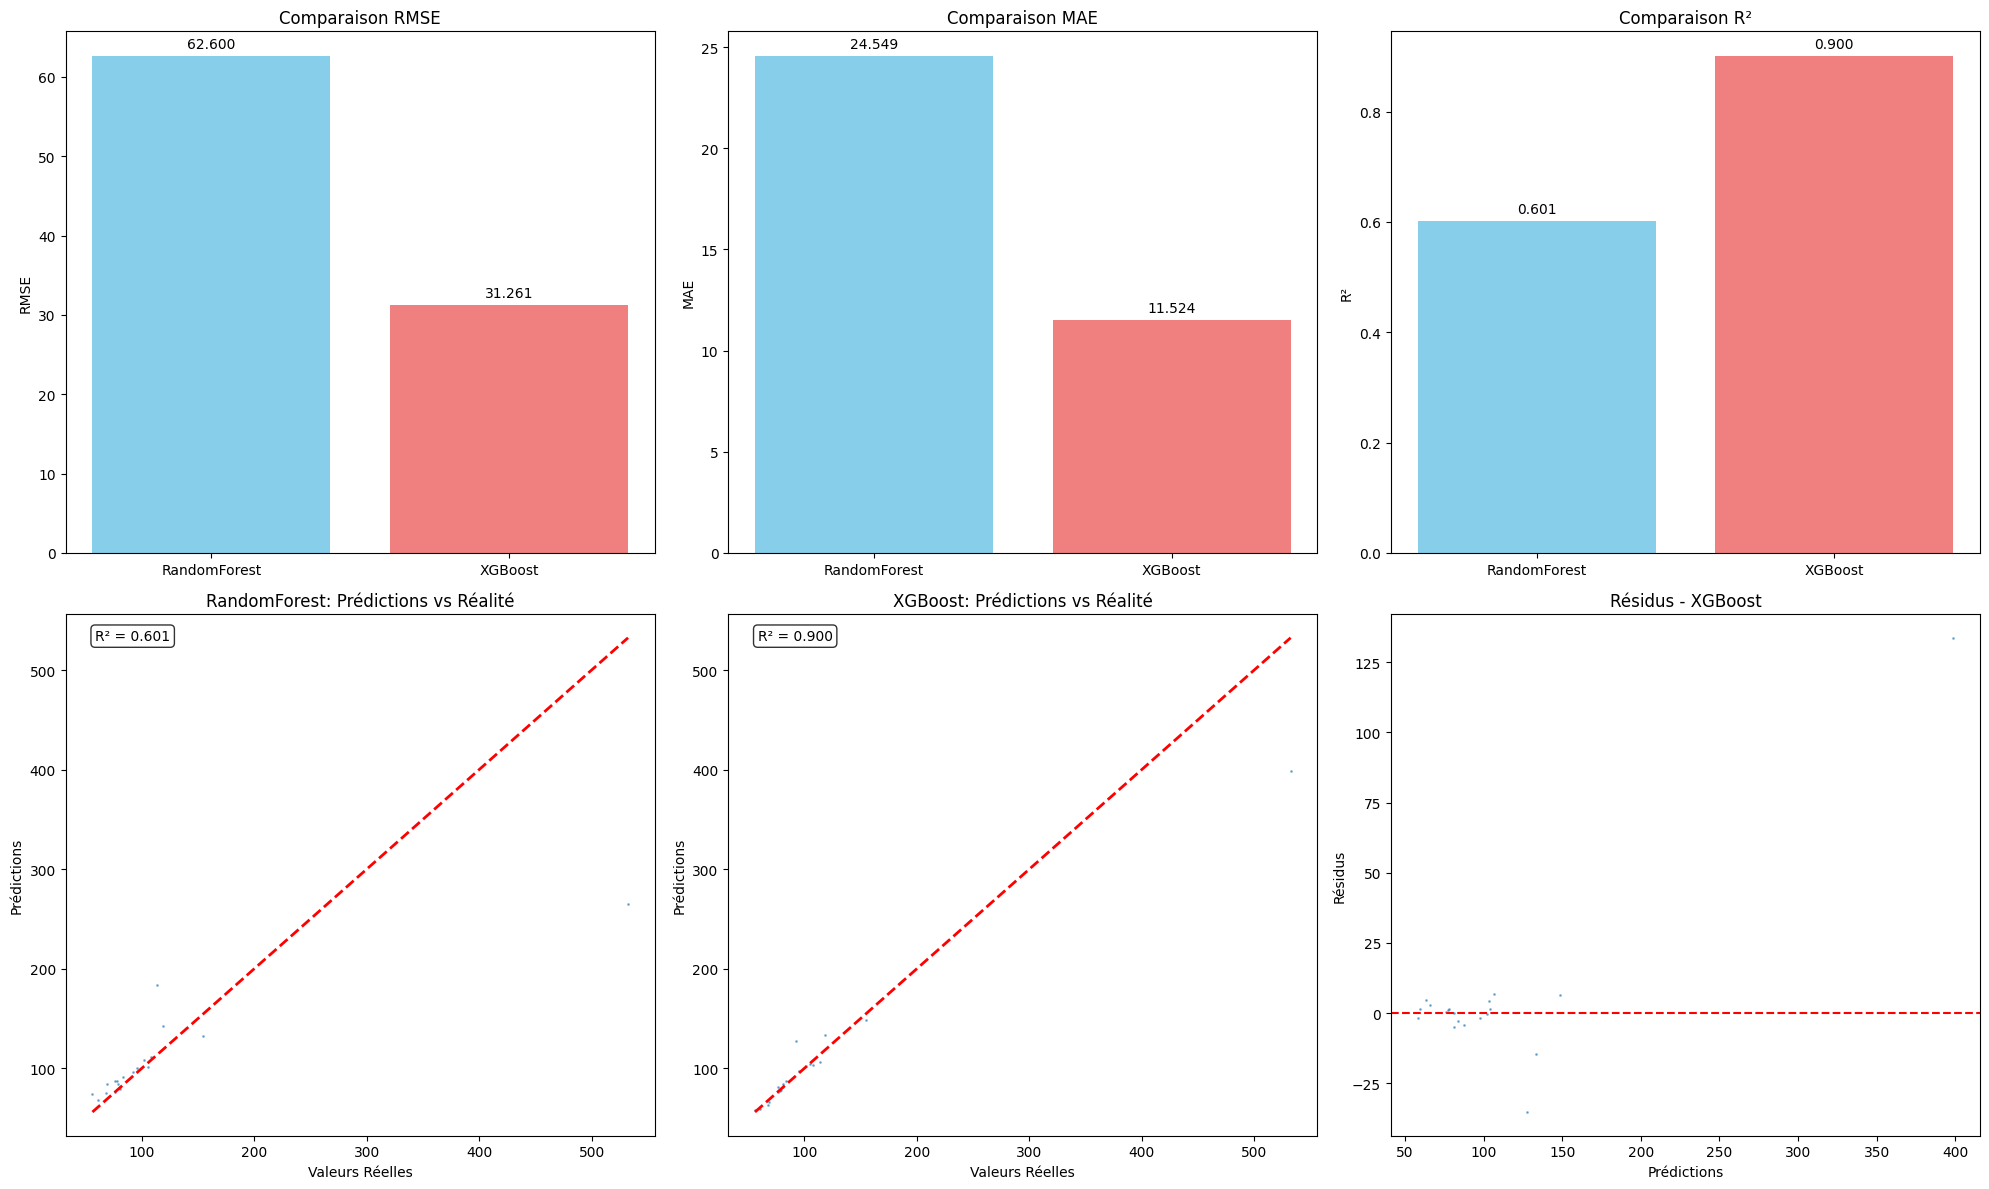

In [ ]:
trainer.plot_model_comparison()

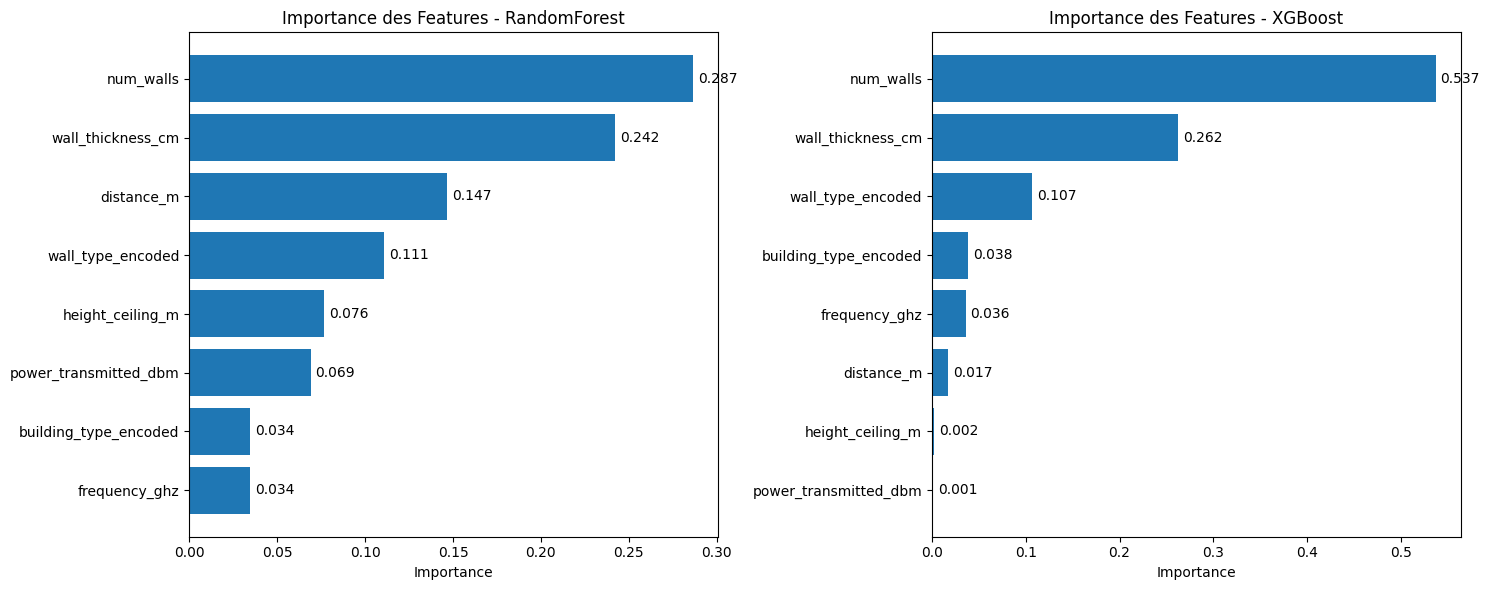

In [ ]:
trainer.plot_feature_importance()

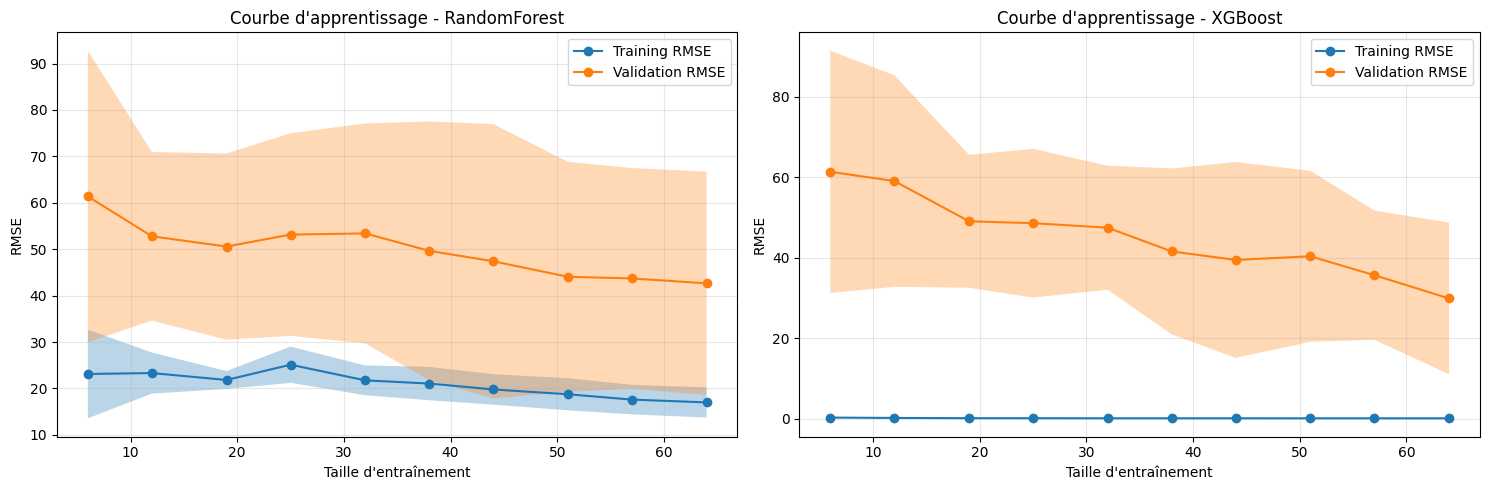

In [ ]:
trainer.plot_learning_curves()

In [ ]:
# Meilleur modèle
best_name, best_model = trainer.get_best_model()


🏆 MEILLEUR MODÈLE: XGBoost
RMSE Test: 31.2612
R² Test: 0.9005


In [ ]:
# Sauvegarder les résultats
trainer.save_results()

Résultats sauvegardés dans model_results.csv


In [ ]:
# prompt: afficher le range de valeur cible

print("Range de valeurs de la cible (path_loss_db):")
print(f"Min: {dataset['path_loss_db'].min():.2f} dB")
print(f"Max: {dataset['path_loss_db'].max():.2f} dB")


Range de valeurs de la cible (path_loss_db):
Min: 41.77 dB
Max: 532.41 dB


In [ ]:
# prompt: je veut maitennt faire un input simple et tester mon modele xgboost

import pandas as pd
def predict_single_input(model, scaler, encoders, feature_names):
    """
    Prend les entrées utilisateur et prédit le path loss.
    """
    print("\n=== PRÉDICTION DU PATH LOSS ===")

    # Demander les entrées à l'utilisateur
    try:
        distance = float(input("Entrez la distance (en mètres, ex: 5.2): "))
        num_walls = int(input("Entrez le nombre de murs traversés (entier, ex: 2): "))
        wall_thickness = float(input("Entrez l'épaisseur moyenne des murs (en cm, ex: 15.0): "))
        height_ceiling = float(input("Entrez la hauteur sous plafond (en mètres, ex: 2.6): "))
        frequency = float(input("Entrez la fréquence WiFi (en GHz, ex: 2.4, 5.0, 5.8, 6.0): "))
        power_transmitted = float(input("Entrez la puissance transmise (en dBm, ex: 15.0): "))

        print("Types de murs disponibles: placo, beton, brique, cloison_bois, verre")
        wall_type_str = input("Entrez le type de mur dominant: ")

        print("Types de bâtiments disponibles: appartement, bureau, maison, warehouse, hopital")
        building_type_str = input("Entrez le type de bâtiment: ")

    except ValueError as e:
        print(f"Erreur de saisie: {e}. Veuillez entrer des nombres valides.")
        return None

    # Encoder les variables catégorielles
    try:
        wall_type_encoded = encoders['wall'].transform([wall_type_str])[0]
        building_type_encoded = encoders['building'].transform([building_type_str])[0]
    except ValueError as e:
        print(f"Erreur lors de l'encodage: {e}. Assurez-vous que les types de murs/bâtiments sont valides.")
        return None


    # Créer un DataFrame pour l'entrée unique
    input_data = pd.DataFrame([[
        distance, num_walls, wall_thickness, height_ceiling,
        frequency, power_transmitted, wall_type_encoded, building_type_encoded
    ]], columns=feature_names)

    # Appliquer la même mise à l'échelle que sur les données d'entraînement
    # Assurez-vous d'utiliser le scaler entraîné sur X_train
    try:
        input_scaled = scaler.transform(input_data)
    except Exception as e:
        print(f"Erreur lors de la mise à l'échelle: {e}")
        print("Vérifiez que le scaler a été correctement entraîné sur les données.")
        return None

    # Faire la prédiction
    try:
        predicted_path_loss = model.predict(input_scaled)[0]
        print(f"\nPrédiction du Path Loss: {predicted_path_loss:.2f} dB")
        return predicted_path_loss
    except Exception as e:
        print(f"Erreur lors de la prédiction: {e}")
        print("Vérifiez que le modèle est correctement entraîné.")
        return None

# --- Utilisation de la fonction d'input et de prédiction ---

# Assurez-vous que le trainer a été exécuté et que le meilleur modèle est disponible
# (Le code précédent dans la cellule l'a déjà fait)

# Récupérer le meilleur modèle et le scaler
best_name, best_model = trainer.get_best_model()
trained_scaler = trainer.scaler # Récupérer le scaler entraîné
trained_feature_names = trainer.X.columns # Récupérer les noms des features utilisés
trained_encoders = {
    'wall': generator.wall_encoder,
    'building': generator.building_encoder
}


if best_model:
    # Appeler la fonction de prédiction avec input utilisateur
    predict_single_input(best_model, trained_scaler, trained_encoders, trained_feature_names)
else:
    print("Aucun modèle entraîné ou sélectionné.")




🏆 MEILLEUR MODÈLE: XGBoost
RMSE Test: 31.2612
R² Test: 0.9005

=== PRÉDICTION DU PATH LOSS ===
Entrez la distance (en mètres, ex: 5.2): 6
Entrez le nombre de murs traversés (entier, ex: 2): 2
Entrez l'épaisseur moyenne des murs (en cm, ex: 15.0): 10
Entrez la hauteur sous plafond (en mètres, ex: 2.6): 3
Entrez la fréquence WiFi (en GHz, ex: 2.4, 5.0, 5.8, 6.0): 5
Entrez la puissance transmise (en dBm, ex: 15.0): 18
Types de murs disponibles: placo, beton, brique, cloison_bois, verre
Entrez le type de mur dominant: placo
Types de bâtiments disponibles: appartement, bureau, maison, warehouse, hopital
Entrez le type de bâtiment: hopital

Prédiction du Path Loss: 51.60 dB


In [ ]:
import math

# Données entrées
distance_m = 6  # mètres
num_walls = 2
wall_thickness_cm = 10  # centimètres
ceiling_height_m = 3  # mètres
frequency_ghz = 5  # GHz
tx_power_dbm = 18  # dBm
wall_type = "placo"
building_type = "hopital"

# Pertes typiques par type de mur (en dB par mur)
wall_loss_db = {
    "placo": 3,
    "beton": 8,
    "brique": 5,
    "cloison_bois": 2,
    "verre": 6,
}

# Pertes approximatives supplémentaires selon le type de bâtiment (en dB)
building_loss_db = {
    "appartement": 5,
    "maison": 7,
    "bureau": 10,
    "warehouse": 12,
    "hopital": 15,
}

# Calcul de la FSPL (Free Space Path Loss)
distance_km = distance_m / 1000
frequency_mhz = frequency_ghz * 1000

fspl_db = 20 * math.log10(distance_km) + 20 * math.log10(frequency_mhz) + 32.44

# Pertes dues aux murs
wall_loss = wall_loss_db.get(wall_type, 5) * num_walls

# Pertes dues au bâtiment
building_loss = building_loss_db.get(building_type, 10)

# Pathloss total
total_pathloss_db = fspl_db + wall_loss + building_loss

print(f"Pathloss estimé : {total_pathloss_db:.2f} dB")


Pathloss estimé : 82.98 dB
